# 1. Install necessary dependencies

In [13]:
%pip install --upgrade --quiet  langchain langchain-neo4j langchain-openai langgraph

In [24]:
os.environ["NEO4J_URI"] = "neo4j+s://01685918.databases.neo4j.io"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "VDcktQ6eWGXbZ2pMPCBjxFQGpej-ZfBoevKTbAQ0tsQ"

# 2. Loading the movies dataset to Neo4j DB

a. Import necessary dependencies

b. Creating a Neo4jGraph Instance

c. Defining the Cypher Query (movies_query)

1. This multi-line string contains a Cypher query that will be executed against the Neo4j database.
2. LOAD CSV WITH HEADERS FROM ...: This Cypher clause loads data from a CSV file hosted on GitHub.
3. AS row: This assigns each row of the CSV file to the variable row.
4. MERGE (m:Movie {id:row.movieId}): This creates or updates a Movie node in the graph. MERGE ensures that a node with the specified id (which is the movieId from the CSV) is created only if it doesn't already exist.
5. SET m.released = date(row.released), m.title = row.title, m.imdbRating = toFloat(row.imdbRating): This sets properties on the Movie node:

m.released: The release date, converted to a Neo4j date type.

m.title: The movie title.

m.imdbRating: The IMDb rating, converted to a floating-point number.

6. FOREACH (director in split(row.director, '|') | ...): This iterates through the directors listed in the director column (which can contain multiple directors separated by |).

MERGE (p:Person {name:trim(director)}): Creates or updates a Person node for each director.

MERGE (p)-[:DIRECTED]->(m): Creates a DIRECTED relationship from the Person node to the Movie node.

7. FOREACH (actor in split(row.actors, '|') | ...): This does the same for actors, creating Person nodes and ACTED_IN relationships.
8. FOREACH (genre in split(row.genres, '|') | ...): This does the same for genres, creating Genre nodes and IN_GENRE relationships.

d. Executing the Cypher Query

Summary

This code connects to a Neo4j database, loads movie data from a CSV file, and creates a graph structure representing movies, people (directors and actors), and genres, with relationships between them. The MERGE operation is used to prevent duplicate nodes, and FOREACH is used to handle multi-valued columns in the CSV.

In [15]:
from langchain_neo4j import Neo4jGraph

graph = Neo4jGraph(refresh_schema=False)

# Import movie information

movies_query = """
LOAD CSV WITH HEADERS FROM
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') |
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') |
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') |
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

graph.query(movies_query)

[]

# 3. Define Custom tools with Cypher templates

1. description_query Cypher Query

Purpose: This query aims to find a movie or person whose title or name contains a specified candidate string ($candidate) and retrieve information about their relationships and properties.

Explanation:

MATCH (m:Movie|Person): Matches nodes with either the "Movie" or "Person" label.

WHERE m.title CONTAINS $candidate OR m.name CONTAINS $candidate: Filters the matched nodes to those whose title or name contains the $candidate parameter.

MATCH (m)-[r:ACTED_IN|IN_GENRE]-(t): Matches the nodes connected to m by either "ACTED_IN" or "IN_GENRE" relationships.

WITH m, type(r) as type, collect(coalesce(t.name, t.title)) as names: Collects the relationship type and the names (or titles) of the related nodes.

WITH m, type+": "+reduce(s="", n IN names | s + n + ", ") as types: Combines the relationship type and names into a formatted string.

WITH m, collect(types) as contexts: Collects all the formatted strings for the relationships.

WITH m, "type:" + labels(m)[0] + "\ntitle: "+ coalesce(m.title, m.name) + "\nyear: "+coalesce(m.released,"") +"\n" + reduce(s="", c in contexts | s + substring(c, 0, size(c)-2) +"\n") as context: Constructs the final context string, including the node label, title/name, release year, and relationship information.

RETURN context LIMIT 1: Returns the constructed context string for the first matched node.

2. get_information Function

Purpose: This function retrieves information about an entity from the Neo4j graph.

Input: It takes an entity string as input, which is the candidate title or name to search for.

Logic:

try...except IndexError: Uses a try-except block to handle the case where no results are found.

data = graph.query(description_query, params={"candidate": entity}): Executes the description_query with the provided entity as the $candidate parameter. The results are stored in the data variable.

return data[0]["context"]: If results are found, it returns the "context" field from the first result.

return "No information was found": If an IndexError occurs (meaning no results were found), it returns the "No information was found" message.

Output: It returns a string containing the information about the entity, or a "No information was found" message if no results are found.

summary:

This code defines a Cypher query and a function to retrieve information about movies or people from a Neo4j graph. The query searches for nodes whose title or name contains a given candidate string and returns a formatted string containing information about the node's relationships and properties. The function executes the query and handles the case where no results are found.

In [16]:
description_query = """
MATCH (m:Movie|Person)
WHERE m.title CONTAINS $candidate OR m.name CONTAINS $candidate
MATCH (m)-[r:ACTED_IN|IN_GENRE]-(t)
WITH m, type(r) as type, collect(coalesce(t.name, t.title)) as names
WITH m, type+": "+reduce(s="", n IN names | s + n + ", ") as types
WITH m, collect(types) as contexts
WITH m, "type:" + labels(m)[0] + "\ntitle: "+ coalesce(m.title, m.name)
       + "\nyear: "+coalesce(m.released,"") +"\n" +
       reduce(s="", c in contexts | s + substring(c, 0, size(c)-2) +"\n") as context
RETURN context LIMIT 1
"""


def get_information(entity: str) -> str:
    try:
        data = graph.query(description_query, params={"candidate": entity})
        return data[0]["context"]
    except IndexError:
        return "No information was found"

# 4. Defines a custom tool called InformationTool

1. Import necessary dependencies

2. InformationInput Model

a. InformationInput(BaseModel): Defines a Pydantic model called InformationInput.

b. entity: str = Field(...): Specifies that the input to the tool should be a dictionary with a single key: entity.

entity: Represents the movie or person's name.

Field(...): Adds metadata to the entity field, including a description.

3. InformationTool Class

a. class InformationTool(BaseTool): Defines a class called InformationTool that inherits from BaseTool.

b. name: str = "Information": Sets the name of the tool to "Information".

c. description: str = "useful for when you need to answer questions about various actors or movies": Sets the description of the tool.

d. args_schema: Type[BaseModel] = InformationInput: Specifies that the input to the tool should conform to the InformationInput model.

e. _run(self, entity: str) -> str: Defines the synchronous _run method, which is called when the tool is executed.

return get_information(entity): Calls the get_information function (from the previous explanation) to retrieve information about the entity and returns the result.

f. async def _arun(self, entity: str) -> str: Defines the asynchronous _arun method, which is called when the tool is executed asynchronously.

return get_information(entity): Calls the get_information function (which is synchronous) and returns the result. Note that if get_information were async, you would await it.

How it Works:

Input: The tool takes an entity string as input, which represents the name of a movie or person.

Information Retrieval: It calls the get_information function to retrieve information about the entity from the data source.

Output: It returns the retrieved information as a string.


In [17]:
from typing import Optional, Type

from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field


class InformationInput(BaseModel):
    entity: str = Field(description="movie or a person mentioned in the question")


class InformationTool(BaseTool):
    name: str = "Information"
    description: str = (
        "useful for when you need to answer questions about various actors or movies"
    )
    args_schema: Type[BaseModel] = InformationInput

    def _run(
        self,
        entity: str,
    ) -> str:
        """Use the tool."""
        return get_information(entity)

    async def _arun(
        self,
        entity: str,
    ) -> str:
        """Use the tool asynchronously."""
        return get_information(entity)

# 5. Define the LangGraph Agent

How it Works:

a. Initialization: The code initializes an LLM, binds the InformationTool to it, and sets up a system message.

b. assistant Node: The assistant function is a node in a LangGraph graph. It takes the current conversation state, combines it with the system message, and sends it to the LLM.

c. LLM Response: The LLM receives the messages and generates a response. If the LLM determines that it needs to retrieve information about a movie, it will use the InformationTool to do so.

d. State Update: The assistant function returns the LLM's response, which will be used to update the conversation state.

In simpler terms:

This code sets up a "smart assistant" that can talk about movies. It has a "tool" that it can use to look up information about movies. When you ask it a question, it uses its "tool" to find the answer and then tells you what it found. It keeps track of what you've already talked about so it can remember the conversation.

In [18]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

llm = ChatOpenAI(model="gpt-4o-mini")

tools = [InformationTool()]
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with finding and explaining relevant information about movies."
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# 6. Define the Langgraph flow and visualize

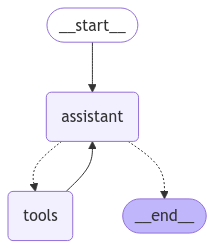

In [19]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

# Invoke the workflow

In [20]:
input_messages = [HumanMessage(content="Who played in the Casino?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who played in the Casino?
================================== Ai Message ==================================
Tool Calls:
  Information (call_pUkSBi0ovbm1UojLPgX6xGiM)
 Call ID: call_pUkSBi0ovbm1UojLPgX6xGiM
  Args:
    entity: Casino
================================= Tool Message =================================
Name: Information

type:Movie
title: Casino
year: 1995-11-22
ACTED_IN: Robert De Niro, Joe Pesci, Sharon Stone, James Woods
IN_GENRE: Drama, Crime

================================== Ai Message ==================================

The movie "Casino," released on November 22, 1995, features the following key actors:

- Robert De Niro
- Joe Pesci
- Sharon Stone
- James Woods

It's a drama and crime film directed by Martin Scorsese.


# Output explanation

Here's a breakdown:

1. Human Message:

================================ Human Message =================================

Who played in the Casino?

This is the initial user query. The user is asking for the actors who played in the movie "Casino."

2. AI Message (Tool Call):

================================== Ai Message ==================================
Tool Calls:
  Information (call_pUkSBi0ovbm1UojLPgX6xGiM)
 Call ID: call_pUkSBi0ovbm1UojLPgX6xGiM
  Args:
    entity: Casino
The agent recognizes that it needs to retrieve information about the movie "Casino" to answer the question.

It uses the "Information" tool (which we defined earlier) to do this.

call_pUkSBi0ovbm1UojLPgX6xGiM: This is a unique identifier for this specific tool call.

Args: entity: Casino: The agent passes "Casino" as the argument to the "Information" tool.

3. Tool Message:

================================= Tool Message =================================
Name: Information

type:Movie

title: Casino

year: 1995-11-22

ACTED_IN: Robert De Niro, Joe Pesci, Sharon Stone, James Woods

IN_GENRE: Drama, Crime

This is the response from the "Information" tool.

It provides the following information about the movie "Casino":

type: Movie: Indicates it's a movie.

title: Casino: The title of the movie.

year: 1995-11-22: The release date of the movie.

ACTED_IN: Robert De Niro, Joe Pesci, Sharon Stone, James Woods: The actors who played in the movie.

IN_GENRE: Drama, Crime: The genres of the movie.

4. AI Message (Final Answer):

================================== Ai Message ==================================

The movie "Casino," released on November 22, 1995, features the following key actors:

- Robert De Niro
- Joe Pesci
- Sharon Stone
- James Woods

It's a drama and crime film directed by Martin Scorsese.

The agent uses the information retrieved from the tool to generate a final answer to the user's question.

It presents the answer in a clear and natural language format.

It also includes the movie's release date and genres, providing additional context.

It also adds that it was directed by Martin Scorsese, which was not available from the tool.

Summary:

The agent received a user question, used a tool to retrieve relevant information from a data source, and then generated a final answer based on the retrieved information. This demonstrates the typical workflow of a LangChain agent that uses tools to interact with external data sources and answer user questions.

In [21]:
input_messages = [HumanMessage(content="Who was the director of Jumanji?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who was the director of Jumanji?
================================== Ai Message ==================================
Tool Calls:
  Information (call_34UrF1N02UgeXkt5tkOR4syw)
 Call ID: call_34UrF1N02UgeXkt5tkOR4syw
  Args:
    entity: Jumanji
================================= Tool Message =================================
Name: Information

type:Movie
title: Jumanji
year: 1995-12-15
ACTED_IN: Robin Williams, Bradley Pierce, Kirsten Dunst, Jonathan Hyde
IN_GENRE: Adventure, Children, Fantasy

================================== Ai Message ==================================
Tool Calls:
  Information (call_vuqgkWohTVZu973qUT2IvLXl)
 Call ID: call_vuqgkWohTVZu973qUT2IvLXl
  Args:
    entity: Jumanji 1995
================================= Tool Message =================================
Name: Information

No information was found
================================== Ai Message ==================================
Tool C

In [22]:
input_messages = [HumanMessage(content="What is the genre of Father of the Bride Part II?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the genre of Father of the Bride Part II?
================================== Ai Message ==================================
Tool Calls:
  Information (call_GzqW8FQtHxriknpXypvDT1od)
 Call ID: call_GzqW8FQtHxriknpXypvDT1od
  Args:
    entity: Father of the Bride Part II
================================= Tool Message =================================
Name: Information

type:Movie
title: Father of the Bride Part II
year: 1995-12-08
ACTED_IN: Diane Keaton, Steve Martin, Kimberly Williams-Paisley, Martin Short
IN_GENRE: Comedy

================================== Ai Message ==================================

The genre of "Father of the Bride Part II" is Comedy.


In [23]:
input_messages = [HumanMessage(content="What is the cast of Dead Man Walking?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the cast of Dead Man Walking?
================================== Ai Message ==================================
Tool Calls:
  Information (call_h2X1nJnPXdVnQeXVUqMyRFEG)
 Call ID: call_h2X1nJnPXdVnQeXVUqMyRFEG
  Args:
    entity: Dead Man Walking
================================= Tool Message =================================
Name: Information

type:Movie
title: Dead Man Walking
year: 1996-02-02
ACTED_IN: Sean Penn, Raymond J. Barry, Susan Sarandon, Robert Prosky
IN_GENRE: Drama, Crime

================================== Ai Message ==================================

The cast of "Dead Man Walking" (1996) includes:

- Sean Penn
- Susan Sarandon
- Raymond J. Barry
- Robert Prosky

This film falls under the genres of Drama and Crime.
